Genre classification of historical newspaper texts

Try to train and test two different classifiers on a collection of texts from [historical New Zealand newspapers](https://paperspast.natlib.govt.nz/newspapers). Our aim is to build genre classification models that are independent of topic, so we will use features based on the structure and layout of the text (for example line widths), linguistic features (such as the frequency of certain parts-of-speech), and other text statistics.

The data used in this notebook is originally sourced from the [National Library of New Zealand's Papers Past open data](https://natlib.govt.nz/about-us/open-data/papers-past-metadata/papers-past-newspaper-open-data-pilot/dataset-papers-past-newspaper-open-data-pilot). It consists of a small dataset of articles that have been pre-labelled with their genre and includes features related to line widths and offsets that have been extracted from the [METS/ALTO XML files](https://veridiansoftware.com/knowledge-base/metsalto/) for each newspaper.

We will use [spaCy](https://spacy.io/) and [textstat](https://pypi.org/project/textstat/) to extract additional features and add them to our dataframe. We will then use [scikit-learn](https://scikit-learn.org/stable/) to train and test our models.

<div style="border:1px solid black;margin-top:1em;padding:0.5em;">
    <strong>Task 0:</strong> Throughout the notebook there are defined tasks for you to do. Watch out for them - they will have a box around them like this! Make sure you take some notes as you go.
</div>

![National Library Papers Past](https://images.ctfassets.net/pwv49hug9jad/6tW2XbQ3rwBfOYilgpZmVQ/468368a1454e2201958401cab2ea7d79/guides-pp-open-data-feature-image.jpg?fm=webp)

[Image source: natlib.govt.nz](https://natlib.govt.nz/about-us/open-data/papers-past-metadata/papers-past-newspaper-open-data-pilot/get-started-papers-past-newspaper-open-data-pilot)

## Setup

We need to make sure the libraries we will need in this notebook are installed (you only need to run this cell once):

In [1]:
!pip install scikit-learn --upgrade
!pip install textstat
# !pip install seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 36.7 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sklearn-compat 0.1.3 requires scikit-learn<1.7,>=1.2, but you have scikit-learn 1.7.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.3/175.3 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 939.4/939.4 kB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 57.8 MB/s eta 0:00:00


Now import the required libraries.

In [2]:
import sys

import pandas as pd
import numpy as np
import math
import pickle
import re

# Classifier training and evaluation
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix
from sklearn.metrics import RocCurveDisplay

# Feature extraction
import spacy
import textstat
from collections import Counter

import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(
    context="notebook",
    style="whitegrid",
    font="sans-serif",
    font_scale=1
    )

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
# spacy.cli.download("en_core_web_sm")  # uncomment if needed
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

In [5]:
from google.colab import files
uploaded = files.upload()

Saving paperspast_4genres_20240502.csv to paperspast_4genres_20240502.csv


## Load and explore the dataset

In [6]:
# Load the dataframe
#filepath = "paperspast_4genres_20240502.csv"
df = pd.read_csv("paperspast_4genres_20240502.csv", index_col=0)

In [7]:
# View the count of articles by genre
display(df.groupby(["genre"])["genre"].count())

,genre
genre,
FamilyNotice,110
Fiction,107
LetterToEditor,110
Poetry,107


In [8]:
# View first ten rows of the dataframe
df.head(10)

,year,month,day,newspaper_id,newspaper,article_id,avg_line_width,min_line_width,max_line_width,line_width_range,avg_line_offset,max_line_offset,min_line_offset,title,text,genre,newspaper_web,article_web
0,1883,12,14,TS,Star,27,492.178571,162,524,362,30.321429,343,12,JUVENILE CRIMINALS.,"TO TMI IDITOS O» TXI STAB. Bib,—la y«u* issue ...",LetterToEditor,https://paperspast.natlib.govt.nz/newspapers/s...,https://paperspast.natlib.govt.nz/newspapers/T...
1,1889,11,7,OW,Otago Witness,137,309.280000,152,412,260,75.800000,400,50,"GOSSIPING MAGGIE,","Your tongue unruly is, dear friend; Try ana cu...",Poetry,https://paperspast.natlib.govt.nz/newspapers/o...,https://paperspast.natlib.govt.nz/newspapers/O...
2,1886,1,30,ESD,Evening Star,48,450.270270,91,474,383,6.594595,355,0,A Father's Lecture.,"By Bill Nye, My Dear Son : Your mother and I w...",Fiction,https://paperspast.natlib.govt.nz/newspapers/e...,https://paperspast.natlib.govt.nz/newspapers/E...
3,1882,3,14,CROMARG,Cromwell Argus,25,283.224490,189,409,220,11.734694,41,0,Selected Poetry.,"THE ""COMING MA N."" A pair of very chubby legs,...",Poetry,https://paperspast.natlib.govt.nz/newspapers/c...,https://paperspast.natlib.govt.nz/newspapers/C...
4,1885,12,12,TT,Tuapeka Times,14,514.688889,193,549,356,10.444444,182,0,MR M'FARLANE IN EXPLANATION.,"(To the Editor.) SlB, — I did not intend troub...",LetterToEditor,https://paperspast.natlib.govt.nz/newspapers/t...,https://paperspast.natlib.govt.nz/newspapers/T...
5,1876,4,27,ODT,Otago Daily Times,4,388.666667,221,481,260,6.000000,18,0,MARRIAGE.,"On the 20th April, at Porto>ello, by tho Rev. ...",FamilyNotice,https://paperspast.natlib.govt.nz/newspapers/o...,https://paperspast.natlib.govt.nz/newspapers/O...
6,1887,1,28,OW,Otago Witness,129,404.685714,59,572,513,58.028571,279,0,A TIRED HOUR.,"1 wish!—"" and then I lean my head upon my hand...",Poetry,https://paperspast.natlib.govt.nz/newspapers/o...,https://paperspast.natlib.govt.nz/newspapers/O...
7,1886,1,30,ESD,Evening Star,50,440.569948,38,475,437,6.204663,181,0,REDBREAST.,"[By James Greenwood, the ""Amateur Casual.""] Th...",Fiction,https://paperspast.natlib.govt.nz/newspapers/e...,https://paperspast.natlib.govt.nz/newspapers/E...
8,1887,1,28,OW,Otago Witness,133,276.192308,102,366,264,113.307692,441,4,A SONG.,"Be stlil my heart, be still, I only heard his ...",Poetry,https://paperspast.natlib.govt.nz/newspapers/o...,https://paperspast.natlib.govt.nz/newspapers/O...
9,1897,4,22,OW,Otago Witness,214,395.608696,2,547,545,81.195652,579,-1,GOLDFIELD BALLADS.,PETEII TO POLLY. All the bloke 3 may laugh and...,Poetry,https://paperspast.natlib.govt.nz/newspapers/o...,https://paperspast.natlib.govt.nz/newspapers/O...


In [9]:
# Because the ID of the newspaper 'Northern Advocate' is 'NA', this has been read-in as NaN
# View the problem by selecting rows where 'newspaper' column equals 'Northern Advocate'
# Look at the 'newspaper_id' column

mask = df["newspaper"] == "Northern Advocate"
display(df.loc[mask])

,year,month,day,newspaper_id,newspaper,article_id,avg_line_width,min_line_width,max_line_width,line_width_range,avg_line_offset,max_line_offset,min_line_offset,title,text,genre,newspaper_web,article_web
21,1891,7,1,NaN,Northern Advocate,19,517.918919,302,545,243,25.297297,232,10,PARUA BAY.,"(To the Editor.) ' i : Sib, — In your issue of...",LetterToEditor,https://paperspast.natlib.govt.nz/newspapers/n...,https://paperspast.natlib.govt.nz/newspapers/N...


In [10]:
# We can fix this by filling the newspaper_id column for our selected rows with the correct code 'NA'
df.loc[mask, "newspaper_id"] = df.loc[mask, "newspaper_id"].fillna("NA")
display(df.loc[mask])

,year,month,day,newspaper_id,newspaper,article_id,avg_line_width,min_line_width,max_line_width,line_width_range,avg_line_offset,max_line_offset,min_line_offset,title,text,genre,newspaper_web,article_web
21,1891,7,1,NA,Northern Advocate,19,517.918919,302,545,243,25.297297,232,10,PARUA BAY.,"(To the Editor.) ' i : Sib, — In your issue of...",LetterToEditor,https://paperspast.natlib.govt.nz/newspapers/n...,https://paperspast.natlib.govt.nz/newspapers/N...


-----------------------------------------------------
Number of newspaper titles in sample dataset: 48
-----------------------------------------------------



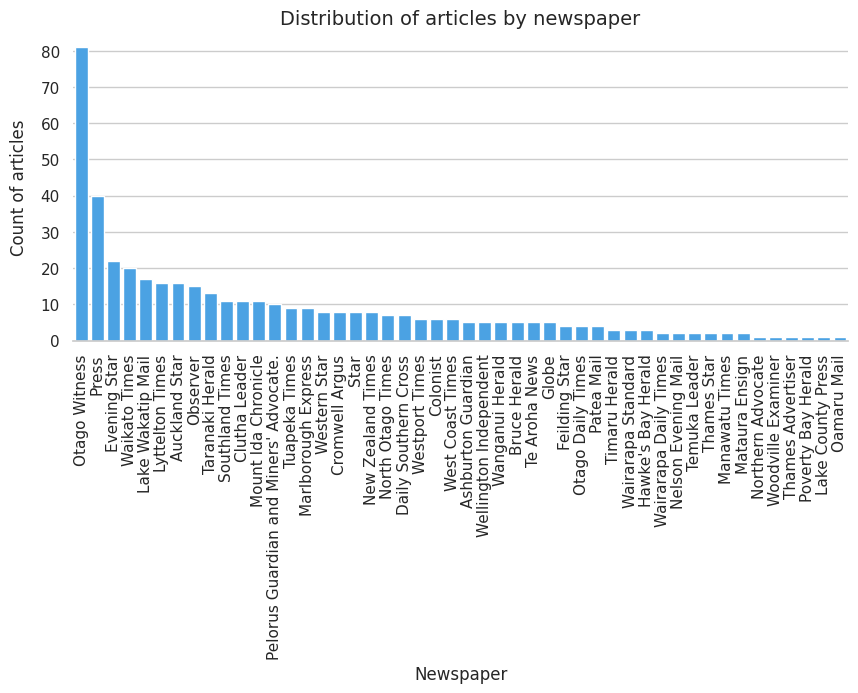

In [11]:
# Let's look at the distribution of the articles in our dataset by newspaper

plt.figure(figsize = (10, 4))
sample_papers_unique = df["newspaper"].nunique()
print("-----------------------------------------------------")
print(f"Number of newspaper titles in sample dataset: {sample_papers_unique}")
print("-----------------------------------------------------")
print("")

ax_1 = sns.countplot(x = "newspaper",
                     data = df,
                     order = df["newspaper"].value_counts().index,
                     color = "#32a5fc")
ax_1.set_xlabel("Newspaper", fontsize = 12)
ax_1.set_ylabel("Count of articles", fontsize = 12, labelpad = 9)
ax_1.set_title("Distribution of articles by newspaper", fontsize = 14)
sns.despine(top = True, right = True, left = True, bottom = False, offset = None, trim = False)
plt.xticks(rotation = 90, fontsize = 11)
plt.yticks(fontsize = 11)
plt.show()

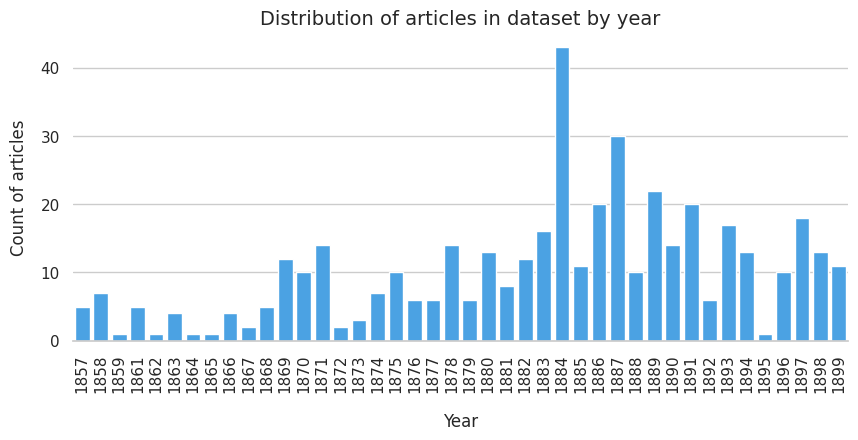

In [12]:
# Now let's view the distribution of the articles in our dataset by year

plt.figure(figsize = (10, 4))
annual_df = (df.groupby(df["year"])
             ["text"].count().reset_index())
ax_2 = sns.barplot(x = "year",
                   y = "text",
                   data = annual_df,
                   color = "#32a5fc")
ax_2.set_xlabel("Year", fontsize = 12, labelpad = 14)
ax_2.set_ylabel("Count of articles", fontsize = 12, labelpad = 9)
ax_2.set_title("Distribution of articles in dataset by year", fontsize = 14)
sns.despine(top = True, right = True, left = True, bottom = False, offset = None, trim = False)
plt.xticks(rotation = 90, fontsize = 11)
plt.yticks(fontsize = 11)
plt.show()

In [13]:
# We can display the full text of a selected article by dataframe index
selected_index = 431

print(f"\nGenre: {df['genre'].values[selected_index]}\n")
print("==============\n")
print(f"Title:\t\t{df['title'].values[selected_index]}")
print(f"Newspaper:\t{df['newspaper'].values[selected_index]}")
print(f"Date:\t\t{df['day'].values[selected_index]} / {df['month'].values[selected_index]} / { df['year'].values[selected_index]}\n")
print(f"{df['text'].values[selected_index]}\n")
print(f"You can view the scanned article on the Papers Past website. "
      f"Follow the link below to see the scan of the original article.\n{df['article_web'].values[selected_index]}\n")


Genre: Poetry


Title:		General.
Newspaper:	Press
Date:		8 / 3 / 1873

TO CHRISTCHURCH. (Being an Ode to My Love.) oWho chose for thee my Christchurch A site so damp and low, Where drains refuse to drain at all Where rivers overflow ? _ Where-»-i£ in short—we wish the worst, To stranger, friend or foe, We need not wish them further, while A Christchurch lies below. Whence came your painted Council Hall, And what the paint's design, Can colors veil a blushing wall When speak thy " Thirty-nine ?" Though bright indeed the setting, Yet how dim the jewels shine, How clear is heard the braying, Though the lion's skin is fine. You only want another knave, To fill the blank that leaves, A Council sage of of " Thirty-nine," In lieu of " Forty Thieves." 'Tis little that our Council does, That little shoWs us done, Like Paul of yore, we suffer sore, From " Forty stripes save one," And what is that unsightly site, Where oft I heard you say, A fair cathedral's stately form, Would bar our daily way

## Data cleaning

We can see from the above that there can be symbols and punctuation in the text that are the result of [OCR](https://en.wikipedia.org/wiki/Optical_character_recognition) errors. We will run a simple cleaner function over the text column of the dataframe to improve this and add the cleaned text to a new column. Before we remove punctuation, we will count the sentences and add this feature to the dataframe.  

In [14]:
def cleaner(df, column_name):
    """
    Given a dataframe column of OCR text, count the sentences, question marks, quotation marks,
    exclamation marks, and apostrophes and store these counts in new columns.

    Remove symbols using a regular expression and create a clean text column.

    Return the updated dataframe.
    """
    # A column of sentence count is added to the dataframe before punctuation is removed.
    df["sentence_count"] = df[column_name].apply(lambda x: textstat.sentence_count(x))

    # Count occurrences of specific characters and add to new columns
    df["freq_q_marks"] = df[column_name].apply(lambda x: x.count("?"))
    df["freq_double_quotes"] = df[column_name].apply(lambda x: x.count('"'))
    df["freq_exclam"] = df[column_name].apply(lambda x: x.count("!"))
    df["freq_apost"] = df[column_name].apply(lambda x: x.count("'"))

    # Regex pattern for only alphanumeric text
    pattern = re.compile(r"[A-Za-z0-9]{1,50}")
    df["clean_text"] = df[column_name].str.findall(pattern).str.join(" ")

    return df

In [15]:
df = cleaner(df, "text")

In [16]:
# Let's look at that same text after 'cleaning'

# We can display the full text of a selected article by index
print(f"\nGenre: {df['genre'].values[selected_index]}\n")
print("==============\n")
print(f"Title:\t\t{df['title'].values[selected_index]}")
print(f"Newspaper:\t{df['newspaper'].values[selected_index]}")
print(f"Date:\t\t{df['day'].values[selected_index]} / {df['month'].values[selected_index]} / {df['year'].values[selected_index]}\n")
print(df["clean_text"].values[selected_index])


Genre: Poetry


Title:		General.
Newspaper:	Press
Date:		8 / 3 / 1873

TO CHRISTCHURCH Being an Ode to My Love oWho chose for thee my Christchurch A site so damp and low Where drains refuse to drain at all Where rivers overflow Where i in short we wish the worst To stranger friend or foe We need not wish them further while A Christchurch lies below Whence came your painted Council Hall And what the paint s design Can colors veil a blushing wall When speak thy Thirty nine Though bright indeed the setting Yet how dim the jewels shine How clear is heard the braying Though the lion s skin is fine You only want another knave To fill the blank that leaves A Council sage of of Thirty nine In lieu of Forty Thieves Tis little that our Council does That little shoWs us done Like Paul of yore we suffer sore From Forty stripes save one And what is that unsightly site Where oft I heard you say A fair cathedral s stately form Would bar our daily way With zeal you laid its bottom No zeal can raise i

In [17]:
# You can see our additional columns have been added to the end of our dataframe
# Scroll across to the right if they are not visible
df.head(5)

,year,month,day,newspaper_id,newspaper,article_id,avg_line_width,min_line_width,max_line_width,line_width_range,...,text,genre,newspaper_web,article_web,sentence_count,freq_q_marks,freq_double_quotes,freq_exclam,freq_apost,clean_text
0,1883,12,14,TS,Star,27,492.178571,162,524,362,...,"TO TMI IDITOS O» TXI STAB. Bib,—la y«u* issue ...",LetterToEditor,https://paperspast.natlib.govt.nz/newspapers/s...,https://paperspast.natlib.govt.nz/newspapers/T...,10,0,0,1,0,TO TMI IDITOS O TXI STAB Bib la y u issue few ...
1,1889,11,7,OW,Otago Witness,137,309.280000,152,412,260,...,"Your tongue unruly is, dear friend; Try ana cu...",Poetry,https://paperspast.natlib.govt.nz/newspapers/o...,https://paperspast.natlib.govt.nz/newspapers/O...,6,0,0,0,5,Your tongue unruly is dear friend Try ana curb...
2,1886,1,30,ESD,Evening Star,48,450.270270,91,474,383,...,"By Bill Nye, My Dear Son : Your mother and I w...",Fiction,https://paperspast.natlib.govt.nz/newspapers/e...,https://paperspast.natlib.govt.nz/newspapers/E...,30,0,11,0,34,By Bill Nye My Dear Son Your mother and I was ...
3,1882,3,14,CROMARG,Cromwell Argus,25,283.224490,189,409,220,...,"THE ""COMING MA N."" A pair of very chubby legs,...",Poetry,https://paperspast.natlib.govt.nz/newspapers/c...,https://paperspast.natlib.govt.nz/newspapers/C...,10,2,8,3,6,THE COMING MA N A pair of very chubby legs Enc...
4,1885,12,12,TT,Tuapeka Times,14,514.688889,193,549,356,...,"(To the Editor.) SlB, — I did not intend troub...",LetterToEditor,https://paperspast.natlib.govt.nz/newspapers/t...,https://paperspast.natlib.govt.nz/newspapers/T...,16,0,20,0,3,To the Editor SlB I did not intend troubling y...


## Feature extraction: linguistic features and text statistics

The following cells extract parts-of-speech and text statistic features and add them to the dataframe. For efficiency, the texts are [processed for parts-of-speech tagging](https://spacy.io/usage/processing-pipelines) as a stream using spaCy's [nlp.pipe](https://spacy.io/usage/processing-pipelines#processing). This allows the texts to be buffered in batches instead of one-by-one.

In [18]:
# Run this cell to define the list of POS tags to count (you don't need to change anything here)
# We will use a selection of Universal POS tags: https://universaldependencies.org/u/pos/

pos_tags = [
            "ADJ",    # adjective
            "ADV",    # adverb
            "NOUN",   # noun
            "NUM",    # numeral
            "PRON",   # pronoun
            "PROPN",  # proper noun
            "VERB",   # verb
            ]

In [19]:
def process_text(df, pos_tags):
    """
    Given a pandas dataframe with a column called "clean_text"
    and a list of Universal parts of speech tags, add columns for
    a list of tokens, word count, relative frequencies
    of the given parts of speech (using Spacy), relative frequencies
    of stopwords, and relative frequencies of monosyllabic words
    and selected punctuation.

    Return the dataframe with the additional columns.
    """
    stop = stopwords.words("english")

    token_list = []
    pos_counts = []
    input_col = "clean_text"

    # Spacy pipeline to count POS
    nlp_text_pipe = nlp.pipe(df[input_col], batch_size = 20)

    for doc in nlp_text_pipe:
        token_list.append([token.text for token in doc if not token.is_punct and not token.is_space])
        pos_counts.append(Counter(token.pos_ for token in doc if token.pos_ in pos_tags))

    df["tokens"] = token_list
    df["word_count"] = df["tokens"].apply(lambda x: len(x))
    df["stopwords_count"] = df[input_col].apply(lambda x: len([i for i in x.split() if i.lower() in stop]))
    df["stopword_relfreq"] = df["stopwords_count"] / df["word_count"]

    pos_columns = set().union(*pos_counts)

    # Compute the relative frequencies of each part-of-speech tag
    for pos in pos_columns:
        df[pos + "_relfreq"] = [count.get(pos, 0) for count in pos_counts] / df["word_count"]

    # Add monsyllabic words relative frequency using the textstat library
    # Add relative frequencies of the punctuation marks counted earlier
    df["monosyll_count"] = df[input_col].apply(lambda x: textstat.monosyllabcount(x))
    df["monosyll_relfreq"] = df["monosyll_count"] / df["word_count"]
    df["q_marks_relfreq"] = df["freq_q_marks"]  / df["word_count"]
    df["double_quotes_relfreq"] = df["freq_double_quotes"] / df["word_count"]
    df["exclam_relfreq"] = df["freq_exclam"]  / df["word_count"]
    df["apost_relfreq"] = df["freq_apost"] / df["word_count"]

    # Drop count columns that are no longer required (they've been converted to relative frequencies)
    df.drop(columns=["tokens",
                     "monosyll_count",
                     "stopwords_count",
                     "freq_q_marks",
                     "freq_double_quotes",
                     "freq_exclam",
                     "freq_apost"], axis = 1, inplace = True)

    return df

In [20]:
# Run the function to extract text features and add them to the dataframe
# This might take a little while to run
df = process_text(df, pos_tags)

In [21]:
# Inspect the first few rows of the dataframe to see the features that have been added
# Scroll to the right
pd.set_option("display.max_columns", None)
df.head(5)

,year,month,day,newspaper_id,newspaper,article_id,avg_line_width,min_line_width,max_line_width,line_width_range,avg_line_offset,max_line_offset,min_line_offset,title,text,genre,newspaper_web,article_web,sentence_count,clean_text,word_count,stopword_relfreq,NOUN_relfreq,PROPN_relfreq,ADV_relfreq,ADJ_relfreq,PRON_relfreq,NUM_relfreq,VERB_relfreq,monosyll_relfreq,q_marks_relfreq,double_quotes_relfreq,exclam_relfreq,apost_relfreq
0,1883,12,14,TS,Star,27,492.178571,162,524,362,30.321429,343,12,JUVENILE CRIMINALS.,"TO TMI IDITOS O» TXI STAB. Bib,—la y«u* issue ...",LetterToEditor,https://paperspast.natlib.govt.nz/newspapers/s...,https://paperspast.natlib.govt.nz/newspapers/T...,10,TO TMI IDITOS O TXI STAB Bib la y u issue few ...,217,0.483871,0.198157,0.069124,0.073733,0.069124,0.096774,0.009217,0.124424,0.714286,0.000000,0.000000,0.004608,0.000000
1,1889,11,7,OW,Otago Witness,137,309.280000,152,412,260,75.800000,400,50,"GOSSIPING MAGGIE,","Your tongue unruly is, dear friend; Try ana cu...",Poetry,https://paperspast.natlib.govt.nz/newspapers/o...,https://paperspast.natlib.govt.nz/newspapers/O...,6,Your tongue unruly is dear friend Try ana curb...,137,0.503650,0.197080,0.029197,0.072993,0.094891,0.153285,0.000000,0.160584,0.802920,0.000000,0.000000,0.000000,0.036496
2,1886,1,30,ESD,Evening Star,48,450.270270,91,474,383,6.594595,355,0,A Father's Lecture.,"By Bill Nye, My Dear Son : Your mother and I w...",Fiction,https://paperspast.natlib.govt.nz/newspapers/e...,https://paperspast.natlib.govt.nz/newspapers/E...,30,By Bill Nye My Dear Son Your mother and I was ...,922,0.574837,0.176790,0.032538,0.066161,0.058568,0.160521,0.008677,0.144252,0.834056,0.000000,0.011931,0.000000,0.036876
3,1882,3,14,CROMARG,Cromwell Argus,25,283.224490,189,409,220,11.734694,41,0,Selected Poetry.,"THE ""COMING MA N."" A pair of very chubby legs,...",Poetry,https://paperspast.natlib.govt.nz/newspapers/c...,https://paperspast.natlib.govt.nz/newspapers/C...,10,THE COMING MA N A pair of very chubby legs Enc...,275,0.389091,0.247273,0.040000,0.040000,0.138182,0.040000,0.010909,0.120000,0.756364,0.007273,0.029091,0.010909,0.021818
4,1885,12,12,TT,Tuapeka Times,14,514.688889,193,549,356,10.444444,182,0,MR M'FARLANE IN EXPLANATION.,"(To the Editor.) SlB, — I did not intend troub...",LetterToEditor,https://paperspast.natlib.govt.nz/newspapers/t...,https://paperspast.natlib.govt.nz/newspapers/T...,16,To the Editor SlB I did not intend troubling y...,345,0.530435,0.182609,0.075362,0.037681,0.052174,0.121739,0.002899,0.124638,0.695652,0.000000,0.057971,0.000000,0.008696


In [22]:
# We can examine use of a selected POS for a given dataframe index

pos_var = 'PRON'
my_ind = 4

#---------------------------------------------------------------------------------------------------#

doc = nlp(df.iloc[my_ind]["clean_text"])
my_text = df.iloc[my_ind]["clean_text"]
stop = stopwords.words("english")
my_pos = [token.text for token in doc if token.pos_ == pos_var]
my_stopwords = [text for text in my_text.split() if text.lower() in stop]

print(f"------------------\nIndex: {my_ind}\n------------------")
display(df.loc[[my_ind]])
print(f"\n------------------")
print(f"Word count: {df.iloc[my_ind]['word_count']}")
print(f"\n------------------")
print(f"{pos_var} relative frequency: {df.iloc[my_ind][f'{pos_var}_relfreq']:.3f}")
print(f"\n------------------")
print(f"Article title:\t\t\t{df.iloc[my_ind]['title']}")
print(f"Scanned newspaper issue:\t{df.iloc[my_ind]['newspaper_web']}\n")
print(f"------------------\nClean text:\n")
print(df.iloc[my_ind][f"clean_text"])
print(f"\n------------------")
print(f"{pos_var} (count = {len(my_pos)}):\n")
print(my_pos)
print("\n------------------\n"
        f"Stopwords (count = {len(my_stopwords)}):\n")
print(my_stopwords)

------------------
Index: 4
------------------


,year,month,day,newspaper_id,newspaper,article_id,avg_line_width,min_line_width,max_line_width,line_width_range,avg_line_offset,max_line_offset,min_line_offset,title,text,genre,newspaper_web,article_web,sentence_count,clean_text,word_count,stopword_relfreq,NOUN_relfreq,PROPN_relfreq,ADV_relfreq,ADJ_relfreq,PRON_relfreq,NUM_relfreq,VERB_relfreq,monosyll_relfreq,q_marks_relfreq,double_quotes_relfreq,exclam_relfreq,apost_relfreq
4,1885,12,12,TT,Tuapeka Times,14,514.688889,193,549,356,10.444444,182,0,MR M'FARLANE IN EXPLANATION.,"(To the Editor.) SlB, — I did not intend troub...",LetterToEditor,https://paperspast.natlib.govt.nz/newspapers/t...,https://paperspast.natlib.govt.nz/newspapers/T...,16,To the Editor SlB I did not intend troubling y...,345,0.530435,0.182609,0.075362,0.037681,0.052174,0.121739,0.002899,0.124638,0.695652,0.0,0.057971,0.0,0.008696



------------------
Word count: 345

------------------
PRON relative frequency: 0.122

------------------
Article title:			MR M'FARLANE IN EXPLANATION.
Scanned newspaper issue:	https://paperspast.natlib.govt.nz/newspapers/tuapeka-times/1885/12/12

------------------
Clean text:

To the Editor SlB I did not intend troubling you further re Hospital matfcer but Beeing Fair play s tetter which I consider an insult to the true meaning of the signature I will gire you briefly the interpretation of my being clo e to the ward merely the distance from the main entrance to ths female ward If you read my last I am sure Sir you will not find any in sinuatious about the warder being under the influence of drink I was not the writer or originator of the letter signed Liberty m Religion Had the writer enquired I should gladly have explained matters to avoid going into print If Warder Duffy did what he was told he would have carried out the Doctor s instructions on the 29th of last month viz to prohi

In [23]:
# We can also inspect summary statistics for all our numerical data
# We will use these later to explore the misclassified articles

df.describe()

,year,month,day,article_id,avg_line_width,min_line_width,max_line_width,line_width_range,avg_line_offset,max_line_offset,min_line_offset,sentence_count,word_count,stopword_relfreq,NOUN_relfreq,PROPN_relfreq,ADV_relfreq,ADJ_relfreq,PRON_relfreq,NUM_relfreq,VERB_relfreq,monosyll_relfreq,q_marks_relfreq,double_quotes_relfreq,exclam_relfreq,apost_relfreq
count,434.000000,434.000000,434.000000,434.000000,434.000000,434.000000,434.000000,434.000000,434.000000,434.000000,434.000000,434.000000,434.000000,434.000000,434.000000,434.000000,434.000000,434.000000,434.000000,434.000000,434.000000,434.000000,434.000000,434.000000,434.000000,434.000000
mean,1883.380184,5.785714,16.094470,33.781106,449.902744,139.108295,534.857143,395.748848,23.449924,173.274194,2.447005,38.990783,738.320276,0.425194,0.189242,0.167985,0.036428,0.060756,0.078921,0.020057,0.102169,0.729447,0.003532,0.012135,0.003843,0.021929
std,10.051630,3.637460,9.399662,41.881892,80.507515,118.927831,71.968320,140.053006,22.064984,139.245744,9.713836,57.359527,1031.517997,0.102940,0.049673,0.165596,0.023733,0.027422,0.051165,0.026415,0.048237,0.076329,0.006701,0.019401,0.007857,0.027982
min,1857.000000,1.000000,1.000000,1.000000,171.576923,2.000000,237.000000,0.000000,0.000000,0.000000,-1.000000,1.000000,11.000000,0.058824,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.461538,0.000000,0.000000,0.000000,0.000000
25%,1878.000000,3.000000,6.000000,8.000000,390.951374,54.000000,493.000000,314.250000,10.666667,35.000000,0.000000,5.000000,89.500000,0.375181,0.166866,0.061084,0.018606,0.047905,0.041304,0.006024,0.080892,0.679766,0.000000,0.000000,0.000000,0.001639
50%,1884.000000,5.000000,17.000000,16.500000,457.610039,97.000000,541.500000,423.500000,16.457541,159.000000,0.000000,13.000000,262.500000,0.458654,0.188770,0.085471,0.040657,0.061396,0.083333,0.010919,0.116442,0.731094,0.000000,0.000786,0.000000,0.012861
75%,1890.750000,9.000000,24.000000,38.000000,506.393519,188.750000,570.000000,496.750000,27.695887,278.750000,1.000000,45.250000,919.750000,0.497845,0.214922,0.233865,0.054011,0.075147,0.117971,0.022135,0.135802,0.782815,0.005120,0.018848,0.004662,0.031505
max,1899.000000,12.000000,31.000000,253.000000,637.000000,637.000000,1093.000000,1065.000000,212.333333,586.000000,112.000000,297.000000,5763.000000,0.617021,0.333333,0.733333,0.091667,0.166667,0.207299,0.176471,0.209302,0.932515,0.061404,0.133333,0.062500,0.233333


In [24]:
# Inspect the full list of columns in our dataframe, and see their data types
display(df.dtypes)

,0
year,int64
month,int64
day,int64
newspaper_id,object
newspaper,object
article_id,int64
avg_line_width,float64
min_line_width,int64
max_line_width,int64
line_width_range,int64


## Specify features to include in the model

* We now need to specify the features we want to include in our model, for example if we know that two features are highly correlated, we can choose to only include one in the model
* We can also include or remove features from the model to explore the impact of different combinations of features on the performance of the classifier.
* **Use the default list shown below first, then experiment to see what effect the changes have on the model**

In [25]:
# List of features to include in the model
# Place cursor in the text and press Ctrl + / to comment or uncomment the line

features = [
            "avg_line_width",
            # "min_line_width",
            # "max_line_width",
            # "line_width_range",
            "avg_line_offset",
            # "max_line_offset",
            # "min_line_offset",
            # "sentence_count",
            "word_count",
            # "stopword_relfreq",
            "VERB_relfreq",
            "ADV_relfreq",
            "PRON_relfreq",
            "ADJ_relfreq",
            "PROPN_relfreq",
            "NOUN_relfreq",
            "NUM_relfreq",
            "monosyll_relfreq",
            # "q_marks_relfreq",
            # "double_quotes_relfreq",
            # "exclam_relfreq",
            # "apost_relfreq",

            # We will code our target genre as a binary class '1' and the other genres as '0'
            # Do not remove this feature from the set
            "binary_class"
           ]

## Set the target genre

* We will specify the genre we want to predict with the binary classifier.
* The selected genre will be labelled as 1 in the binary classification model, with the other classes labelled as 0.

In [26]:
# Select from:
# FamilyNotice
# Fiction
# LetterToEditor
# Poetry

target_genre = "Poetry"

## Split the data into train and test sets

* Run the cells below to split the data into train and test data sets.

In [27]:
def train_test_data(df, features, target_genre):
    """
    Given the dataframe, features to include in the model,
    and the target genre, split the data into
    training and test sets and use the dataframe indices to
    save the order of the split
    """

    df["binary_class"] = np.where(df["genre"]== target_genre, 1, 0)
    model_df = df.filter(features, axis=1)
    indices = df.index.values

    # Extract the explanatory variables in X and the target variable in y
    y = model_df.binary_class.copy()
    X = model_df.drop(["binary_class"], axis=1)

    # Train test split
    # Use the indices to save the order of the split.
    # https://stackoverflow.com/questions/48947194/add-randomforestclassifier-predict-proba-results-to-original-dataframe
    X_train, X_test, indices_train, indices_test = train_test_split(X,
                                                                    indices,
                                                                    test_size = .3,    # This value changes the proportion of data held out for the test set
                                                                    random_state = 7)  # You can change the random state to change the allocation of docs to the training and test sets

    y_train, y_test = y[indices_train], y[indices_test]

    return X_train, X_test, y_train, y_test, indices_train, indices_test

In [28]:
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_data(df, features, target_genre)

In [29]:
X_train.head(10)

,avg_line_width,avg_line_offset,word_count,VERB_relfreq,ADV_relfreq,PRON_relfreq,ADJ_relfreq,PROPN_relfreq,NOUN_relfreq,NUM_relfreq,monosyll_relfreq
53,501.523810,19.761905,146,0.109589,0.047945,0.109589,0.047945,0.089041,0.191781,0.006849,0.657534
292,441.653846,24.115385,193,0.108808,0.025907,0.082902,0.082902,0.165803,0.233161,0.015544,0.761658
245,539.669492,6.830508,1704,0.124413,0.058099,0.148474,0.063967,0.049296,0.171362,0.009390,0.734742
360,532.111111,20.222222,592,0.103041,0.032095,0.074324,0.048986,0.092905,0.214527,0.001689,0.692568
66,390.151515,16.303030,197,0.137056,0.050761,0.152284,0.060914,0.096447,0.167513,0.000000,0.807107
370,453.005435,8.146739,2632,0.121960,0.060030,0.110942,0.061170,0.084726,0.165653,0.012158,0.716185
328,325.772727,52.795455,237,0.160338,0.063291,0.113924,0.050633,0.097046,0.194093,0.000000,0.822785
246,534.285714,18.857143,356,0.092697,0.028090,0.044944,0.047753,0.280899,0.202247,0.016854,0.741573
99,476.777778,12.291667,499,0.178357,0.048096,0.188377,0.040080,0.040080,0.162325,0.014028,0.803607
15,521.900585,12.356725,1428,0.141457,0.058123,0.135854,0.058123,0.034314,0.186275,0.010504,0.782213


In [30]:
y_train.head(10)

,binary_class
53,0
292,0
245,0
360,0
66,1
370,0
328,1
246,0
99,0
15,0


## Train and Test a Logistic Regression Classifier
* [Logistic regression](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression) is a binary classification method popular for its computational efficiency and interpretability.
* Run the cells below to train and test a logistic regression classifier for our selected genre.

In [31]:
def log_reg_binary(X_train, X_test, y_train, y_test, target_genre):
    """
    Train a logistic regression model to classify the selected genre
    """
    pipe = Pipeline([("scl", StandardScaler()),
                     ("clf", LogisticRegression())])
    pipe.fit(X_train, y_train)

    y_pred_train = pipe.predict(X_train)
    y_pred_test = pipe.predict(X_test)
    y_prob_train = pipe.predict_proba(X_train)
    y_prob_test = pipe.predict_proba(X_test)

    accuracy_result = accuracy_score(y_test, y_pred_test)
    precision_result = precision_score(y_test, y_pred_test)
    recall_result = recall_score(y_test, y_pred_test)
    f1_result = f1_score(y_test, y_pred_test)
    auroc_result = roc_auc_score(y_test, y_prob_test[:, 1])  # Use probabilities for AUROC

    print("-----------------------------------------------")
    print(f"Binary Classification - Logistic Regression")
    print(f"Target genre: {target_genre}")
    print("-----------------------------------------------")
    print()
    print(f"Accuracy = {accuracy_result:.3f}")
    print(f"Precision = {precision_result:.3f}")
    print(f"Recall = {recall_result:.3f}")
    print(f"F1 Score = {f1_result:.3f}")
    print(f"AUROC Score = {auroc_result:.3f}")

    RocCurveDisplay.from_predictions(y_test, y_prob_test[:, 1])  # Use probabilities for ROC curve
    plt.title("AUROC: Logistic Regression")
    plt.show()

    print()
    print("-----------------------------------------------")
    print(f"Model coefficients \nwith log odds (logit) converted to odds ratio\nfor improved interpretability\n")
    print(f"Target genre: {target_genre}")
    print("-----------------------------------------------")

    # Get coefficients (log odds or logit)
    log_odds = pipe.named_steps["clf"].coef_[0]
    # Convert log odds to odds ratio
    odds = np.exp(log_odds)

    return y_pred_train, y_pred_test, y_prob_train, y_prob_test, log_odds, odds

In [32]:
def genres_binary_lr(df, target_genre, X_train, X_test, y_train, y_test, indices_train, indices_test):
    """
    Train and test the model, and return the dataframe
    with appended predictions.
    """

    y_pred_train, y_pred_test, y_prob_train, y_prob_test, log_odds, odds = log_reg_binary(X_train,
                                                                                          X_test,
                                                                                          y_train,
                                                                                          y_test,
                                                                                          target_genre
                                                                                         )

    # # Add the predictions to a copy of the original dataframe
    df_new = df.copy()
    df_new.loc[indices_train,"pred_train"] = y_pred_train
    df_new.loc[indices_test,"pred_test"] = y_pred_test
    df_new.loc[indices_train,"prob_0_train"] = y_prob_train[:,0]
    df_new.loc[indices_test,"prob_0_test"] = y_prob_test[:,0]
    df_new.loc[indices_train,"prob_1_train"] = y_prob_train[:,1]
    df_new.loc[indices_test,"prob_1_test"] = y_prob_test[:,1]

    # Sort the dataframe by probability of being the given genre
    df_new = df_new.sort_values(by="prob_1_test", ascending=False)

    # Create a dataframe with both log odds and odds
    lr_odds_df = pd.DataFrame({
        "feature": X_train.columns,
        "log odds (logit)": log_odds,
        "odds ratio": odds
    })

    # Sort the dataframe by odds in descending order
    lr_odds_df = lr_odds_df.sort_values(by="odds ratio", ascending=False)

    # Reset the index for cleaner display
    lr_odds_df = lr_odds_df.reset_index(drop=True)

    return df_new, lr_odds_df

-----------------------------------------------
Binary Classification - Logistic Regression
Target genre: Poetry
-----------------------------------------------

Accuracy = 0.969
Precision = 0.935
Recall = 0.935
F1 Score = 0.935
AUROC Score = 0.995


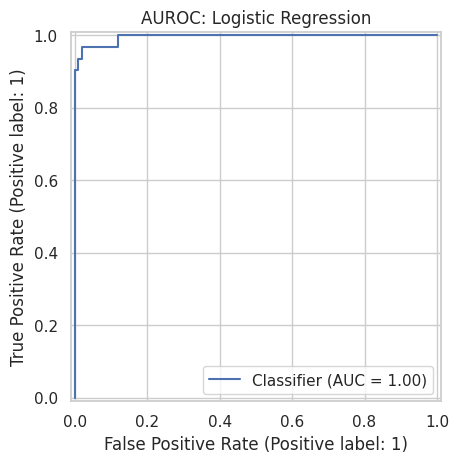


-----------------------------------------------
Model coefficients 
with log odds (logit) converted to odds ratio
for improved interpretability

Target genre: Poetry
-----------------------------------------------


,feature,log odds (logit),odds ratio
0,monosyll_relfreq,2.050212,7.769548
1,VERB_relfreq,1.503009,4.495194
2,avg_line_offset,1.251193,3.494509
3,ADJ_relfreq,0.956982,2.603825
4,NOUN_relfreq,0.833751,2.301938
5,ADV_relfreq,0.292915,1.340329
6,PRON_relfreq,0.008891,1.008931
7,PROPN_relfreq,-0.426424,0.652840
8,NUM_relfreq,-0.992146,0.370780
9,avg_line_width,-1.347139,0.259983


In [33]:
lr_preds_df, lr_odds_df = genres_binary_lr(df, target_genre, X_train, X_test, y_train, y_test, indices_train, indices_test)

# Explore the model coefficients
display(lr_odds_df)

### Interpreting the logistic regression model
A benefit of logistic regression is that it is relatively easy to interpret compared to other classifiers. We can extract the coefficients of the features in the final model (using the 'coef_' attribute) to see which features were the strongest predictors of the positive class (in our case, the selected genre).

The coefficients extracted using 'coef_' are the log odds (logit) that an observation belongs to the positive class. In order to interpret them more easily, we can convert them to the odds ratio. An odds ratio greater than 1 represents a positive association and can be interpreted as follows:

**"For every unit increase in {feature}, the odds that the observation is {positive class} are {odds ratio} times greater than the odds that it is not {positive class} when all other variables are held constant."**

An odds ratio less than 1 represents a negative association. To describe them in a similar way to the above, we need to take 1/odds ratio. For example:

"For every unit increase in {feature}, the odds that the observation **is not** {positive class} are {1 / odds ratio} times greater than the odds that it **is** {positive class} when all other variables are held constant."

**When interpreting the model coefficients it is important to consider the influence of features that may be correlated with each other (multicollinearity). These features will have similar predictive relationships to the outcome and therefore the sign and value of the coefficients should be interpreted with caution.**

You can read more about calculating and interpreting the coefficients of regression models in this [Towards Data Science](https://towardsdatascience.com/interpreting-coefficients-in-linear-and-logistic-regression-6ddf1295f6f1) article.

## Train and Test a Decision Tree classifier
* [Decision Tree](https://scikit-learn.org/stable/modules/tree.html) methods are useful because they are very easy to apply and interpret, however, the results can be susceptible to small changes in the dataset and they don't work so well for imbalanced datasets (is this a problem with our dataset?).
* Run the cells below to train and test a Decision Tree classifier for our selected genre and compare the results to the logistic regression model.

In [34]:
def dt_binary(X_train, X_test, y_train, y_test, target_genre, features):
    """
    Train a decision tree to classify the selected genre
    """
    pipe = Pipeline([("clf",
                      DecisionTreeClassifier(random_state=343,
                                             max_depth = 3 # Limiting the depth of the tree can help to prevent overfitting
                                            )
                     )])
    pipe.fit(X_train, y_train)

    y_pred_train = pipe.predict(X_train)
    y_pred_test = pipe.predict(X_test)

    y_prob_train = pipe.predict_proba(X_train)
    y_prob_test = pipe.predict_proba(X_test)

    accuracy_result = accuracy_score(y_test, y_pred_test)
    precision_result = precision_score(y_test, y_pred_test)
    recall_result = recall_score(y_test, y_pred_test)
    f1_result = f1_score(y_test, y_pred_test)
    auroc_result = roc_auc_score(y_test, y_prob_test[:, 1])  # Use probabilities for AUROC

    print("-----------------------------------------------")
    print(f"Binary Classification - Decision Tree")
    print(f"{target_genre}")
    print("-----------------------------------------------")
    print()
    print(f"Accuracy = {accuracy_result:.3f}")
    print(f"Precision = {precision_result:.3f}")
    print(f"Recall = {recall_result:.3f}")
    print(f"F1 Score = {f1_result:.3f}")
    print(f"AUROC Score = {auroc_result:.3f}")

    RocCurveDisplay.from_predictions(y_test, y_prob_test[:, 1])  # Use probabilities for ROC curve
    plt.title("AUROC: Decision Tree")
    plt.show()

    plt.figure(figsize=(20,10))
    print(f"\n\nInterpreting the decision tree: if the condition in the box (node) is TRUE, take the LEFT branch. If FALSE, take the RIGHT.\n")
    plot_tree(pipe["clf"],
              feature_names=features[:-1],
              class_names=["Other", target_genre],
              filled=True,
              impurity=False,
              rounded=True,
              fontsize=14
              )
    plt.show()

    return y_pred_train, y_pred_test, y_prob_train, y_prob_test

In [35]:
def genres_binary_dt(df, target_genre, X_train, X_test, y_train, y_test, indices_train, indices_test, features):
    """
    Train and test the model, and return the dataframe
    with appended predictions.
    """

    y_pred_train, y_pred_test, y_prob_train, y_prob_test = dt_binary(X_train,
                                                                     X_test,
                                                                     y_train,
                                                                     y_test,
                                                                     target_genre,
                                                                     features)

    # Add the predictions to a copy of the original dataframe
    df_new = df.copy()
    df_new.loc[indices_train,"pred_train"] = y_pred_train
    df_new.loc[indices_test,"pred_test"] = y_pred_test
    df_new.loc[indices_train,"prob_0_train"] = y_prob_train[:,0]
    df_new.loc[indices_test,"prob_0_test"] = y_prob_test[:,0]
    df_new.loc[indices_train,"prob_1_train"] = y_prob_train[:,1]
    df_new.loc[indices_test,"prob_1_test"] = y_prob_test[:,1]

    # Sort the dataframe by probability of being the given genre
    df_new = df_new.sort_values(by="prob_1_test", ascending=False)

    return df_new

-----------------------------------------------
Binary Classification - Decision Tree
Poetry
-----------------------------------------------

Accuracy = 0.870
Precision = 0.719
Recall = 0.742
F1 Score = 0.730
AUROC Score = 0.859


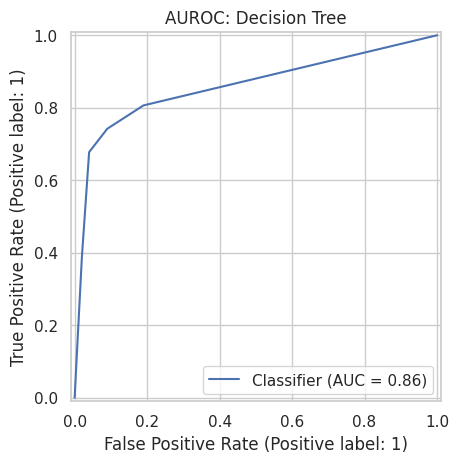



Interpreting the decision tree: if the condition in the box (node) is TRUE, take the LEFT branch. If FALSE, take the RIGHT.



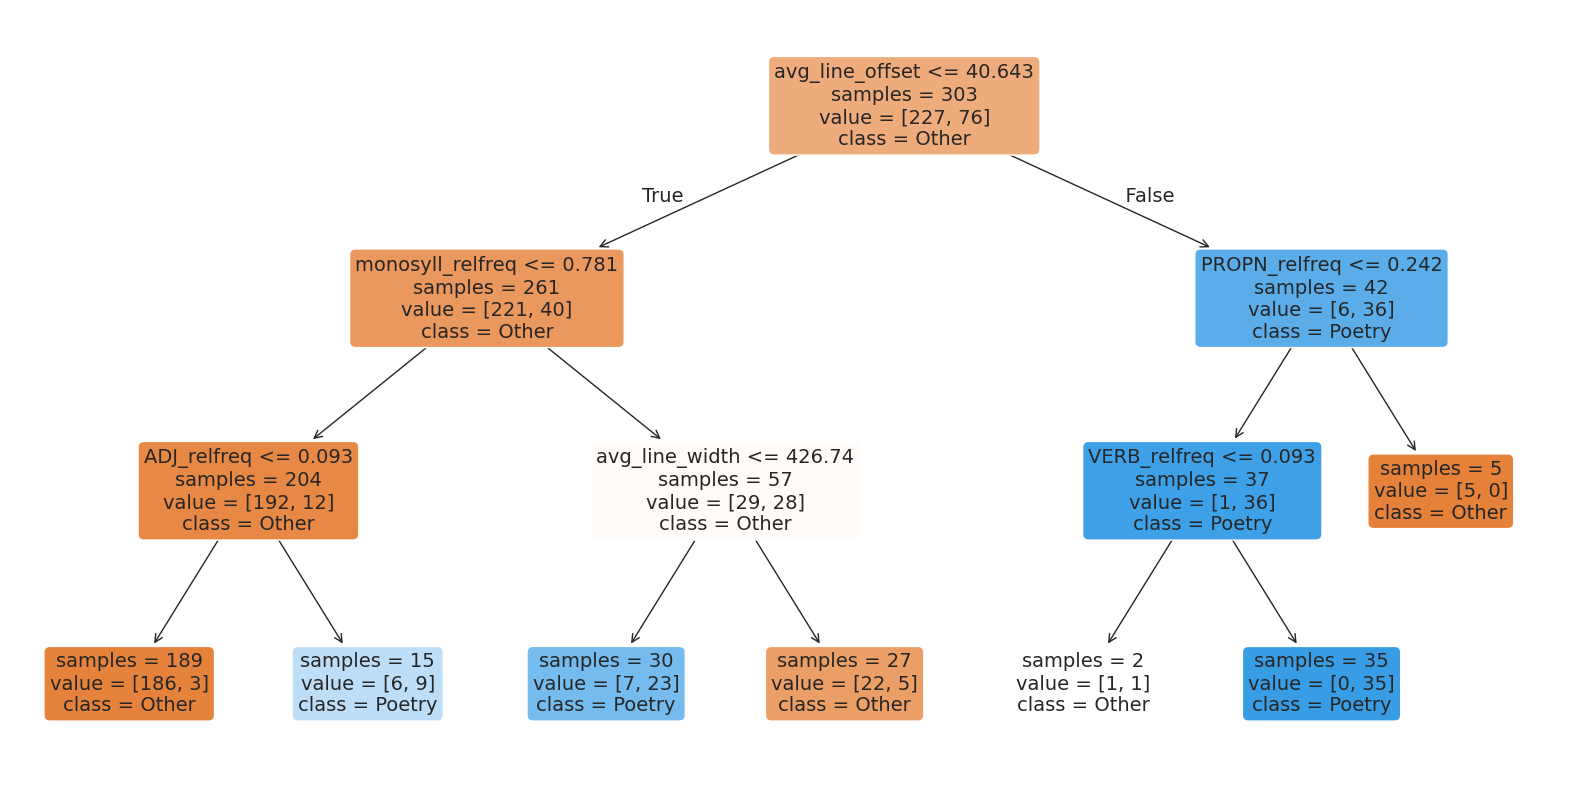

In [36]:
dt_preds_df = genres_binary_dt(df, target_genre, X_train, X_test, y_train, y_test, indices_train, indices_test, features)

## Inspect incorrectly classified texts

We can explore which texts were incorrectly classified by the two models. Run the cell below to display dataframes of the misclassified texts.

In [37]:
pd.set_option("display.max_columns", None)

lr_misclass = lr_preds_df.loc[(lr_preds_df["binary_class"] != lr_preds_df["pred_test"]) & (lr_preds_df["pred_test"] >= 0)]
lr_misclass = lr_misclass.filter(["date",
                                  "newspaper_id",
                                  "newspaper",
                                  "article_id",
                                  "title",
                                  "text",
                                  "clean_text",
                                  "genre",
                                  "binary_class",
                                  "pred_test",
                                  "article_web"],
                                  axis=1
                                ).reset_index(drop=True)

print(f"\nMisclassified texts for Logistic Regression model (lr)")
print(f"{target_genre}")
print("========================================================\n")
display(lr_misclass)

dt_misclass = dt_preds_df.loc[(dt_preds_df["binary_class"] != dt_preds_df["pred_test"]) & (dt_preds_df["pred_test"] >= 0)]
dt_misclass = dt_misclass.filter(["date",
                                  "newspaper_id",
                                  "newspaper",
                                  "article_id",
                                  "title",
                                  "text",
                                  "clean_text",
                                  "genre",
                                  "binary_class",
                                  "pred_test",
                                  "article_web"],
                                  axis=1
                                ).reset_index(drop=True)

print(f"\nMisclassified texts for Decision Tree model (dt)")
print(f"{target_genre}")
print("========================================================\n")
display(dt_misclass)


Misclassified texts for Logistic Regression model (lr)
Poetry



,newspaper_id,newspaper,article_id,title,text,clean_text,genre,binary_class,pred_test,article_web
0,TH,Taranaki Herald,3,BIRTHS.,"On the 31st ult., the wife of William Gray of ...",On the 31st ult the wife of William Gray of a ...,FamilyNotice,0,1.0,https://paperspast.natlib.govt.nz/newspapers/T...
1,ESD,Evening Star,48,A Father's Lecture.,"By Bill Nye, My Dear Son : Your mother and I w...",By Bill Nye My Dear Son Your mother and I was ...,Fiction,0,1.0,https://paperspast.natlib.govt.nz/newspapers/E...
2,WT,Waikato Times,33,Two Pictures.,"A sixkin'u sun in the ruddy ""VY -sf, A soiilin...",A sixkin u sun in the ruddy VY sf A soiilin sk...,Poetry,1,0.0,https://paperspast.natlib.govt.nz/newspapers/W...
3,TO,Observer,23,Ten Little Cyclists.,"Ten little cyclists scorching in a line, One b...",Ten little cyclists scorching in a line One bu...,Poetry,1,0.0,https://paperspast.natlib.govt.nz/newspapers/T...



Misclassified texts for Decision Tree model (dt)
Poetry



,newspaper_id,newspaper,article_id,title,text,clean_text,genre,binary_class,pred_test,article_web
0,CHP,Press,11,Correspondence.,HEATHCOTE ELECTION. TO THE EDITOB OF THE PKESB...,HEATHCOTE ELECTION TO THE EDITOB OF THE PKESB ...,LetterToEditor,0,1.0,https://paperspast.natlib.govt.nz/newspapers/C...
1,CHP,Press,10,THE SUPERNATURAL.,"TO THB EDITOR OT TH~ PRBSS. Sir, —I understand...",TO THB EDITOR OT TH PRBSS Sir I understand fro...,LetterToEditor,0,1.0,https://paperspast.natlib.govt.nz/newspapers/C...
2,TH,Taranaki Herald,3,BIRTHS.,"On the 31st ult., the wife of William Gray of ...",On the 31st ult the wife of William Gray of a ...,FamilyNotice,0,1.0,https://paperspast.natlib.govt.nz/newspapers/T...
3,WI,Wellington Independent,7,BIRTH.,"Frastbb!— On the 11th in B tant, the wife of M...",Frastbb On the 11th in B tant the wife of Mr F...,FamilyNotice,0,1.0,https://paperspast.natlib.govt.nz/newspapers/W...
4,THD,Timaru Herald,10,LAND ON DEFERRED PAYMENTS.,"TO THE EDITOR OP THB TIMARU HERALD. Srß, — The...",TO THE EDITOR OP THB TIMARU HERALD Sr The ques...,LetterToEditor,0,1.0,https://paperspast.natlib.govt.nz/newspapers/T...
5,DSC,Daily Southern Cross,9,DIED.,"On Monday, the 11th instant, Mary, second daug...",On Monday the 11th instant Mary second daughte...,FamilyNotice,0,1.0,https://paperspast.natlib.govt.nz/newspapers/D...
6,ST,Southland Times,6,DEATH.,"ALLAN.— At Teviot street, Invercargill, on 4th...",ALLAN At Teviot street Invercargill on 4th Nov...,FamilyNotice,0,1.0,https://paperspast.natlib.govt.nz/newspapers/S...
7,WH,Wanganui Herald,3,MARRIAGE.,Stjisted—Davidsox.—On the 7th iust by the Eev ...,Stjisted Davidsox On the 7th iust by the Eev J...,FamilyNotice,0,1.0,https://paperspast.natlib.govt.nz/newspapers/W...
8,WT,Waikato Times,33,AGRICULTURAL EDUCATION.,"TO THE EDITOR. Sill,—The consideration of thte...",TO THE EDITOR Sill The consideration of thte i...,LetterToEditor,0,1.0,https://paperspast.natlib.govt.nz/newspapers/W...
9,CROMARG,Cromwell Argus,18,SELECTED POETRY.,"1 '/""' ;, the' last supper. !.: ; .By Joaquin ...",1 the last supper By Joaquin Millkk What song ...,Poetry,1,0.0,https://paperspast.natlib.govt.nz/newspapers/C...


### Display the full text, the feature values, and the newspaper web address of a selected misclassification by model and index

In [38]:
# Select the model and index number of the misclassified text

# Enter 'lr' or 'dt'
model_code = "lr"
selected_index = 0

##################################################################

if model_code == "lr":
    article_title = f"{lr_misclass['title'].values[selected_index]}"
    article_text = f"{lr_misclass['text'].values[selected_index]}"
    print("\nTitle:")
    print("--------------")
    print(f"{article_title}")
    print("\nText:")
    print("--------------")
    print(article_text)
    print("\nCleaned text:")
    print("--------------")
    print(lr_misclass["clean_text"].values[selected_index])
    print("\nView the scanned article on the Papers Past website")
    print(lr_misclass['article_web'].values[selected_index])

elif model_code == "dt":
    article_title = f"{dt_misclass['title'].values[selected_index]}"
    article_text = f"{dt_misclass['text'].values[selected_index]}"
    print("\nTitle:")
    print("--------------")
    print(f"{article_title}")
    print("\nOriginal OCR text:")
    print("--------------")
    print(article_text)
    print("\nCleaned text:")
    print("--------------")
    print(dt_misclass["clean_text"].values[selected_index])
    print("\nView the scanned article on the Papers Past website")
    print(f"{dt_misclass['article_web'].values[selected_index]}\n")
else:
    print("\nPlease enter either 'lr' or 'dt' for the model code")

mask = (df['title'] == article_title) & (df['text'] == article_text)
display(df.loc[mask])


Title:
--------------
BIRTHS.

Text:
--------------
On the 31st ult., the wife of William Gray of a daughter. On the Ist inst., the wife of the Revd. H. Groube of a son.

Cleaned text:
--------------
On the 31st ult the wife of William Gray of a daughter On the Ist inst the wife of the Revd H Groube of a son

View the scanned article on the Papers Past website
https://paperspast.natlib.govt.nz/newspapers/TH18570905.2.5


,year,month,day,newspaper_id,newspaper,article_id,avg_line_width,min_line_width,max_line_width,line_width_range,avg_line_offset,max_line_offset,min_line_offset,title,text,genre,newspaper_web,article_web,sentence_count,clean_text,word_count,stopword_relfreq,NOUN_relfreq,PROPN_relfreq,ADV_relfreq,ADJ_relfreq,PRON_relfreq,NUM_relfreq,VERB_relfreq,monosyll_relfreq,q_marks_relfreq,double_quotes_relfreq,exclam_relfreq,apost_relfreq,binary_class
79,1857,9,5,TH,Taranaki Herald,3,257.25,70,432,362,9.5,19,0,BIRTHS.,"On the 31st ult., the wife of William Gray of ...",FamilyNotice,https://paperspast.natlib.govt.nz/newspapers/t...,https://paperspast.natlib.govt.nz/newspapers/T...,5,On the 31st ult the wife of William Gray of a ...,26,0.5,0.269231,0.192308,0.0,0.0,0.0,0.0,0.038462,0.884615,0.0,0.0,0.0,0.0,0


In [39]:
# Inspect summary statistics for the whole dataset to compare to the misclassified text
df.describe()

,year,month,day,article_id,avg_line_width,min_line_width,max_line_width,line_width_range,avg_line_offset,max_line_offset,min_line_offset,sentence_count,word_count,stopword_relfreq,NOUN_relfreq,PROPN_relfreq,ADV_relfreq,ADJ_relfreq,PRON_relfreq,NUM_relfreq,VERB_relfreq,monosyll_relfreq,q_marks_relfreq,double_quotes_relfreq,exclam_relfreq,apost_relfreq,binary_class
count,434.000000,434.000000,434.000000,434.000000,434.000000,434.000000,434.000000,434.000000,434.000000,434.000000,434.000000,434.000000,434.000000,434.000000,434.000000,434.000000,434.000000,434.000000,434.000000,434.000000,434.000000,434.000000,434.000000,434.000000,434.000000,434.000000,434.000000
mean,1883.380184,5.785714,16.094470,33.781106,449.902744,139.108295,534.857143,395.748848,23.449924,173.274194,2.447005,38.990783,738.320276,0.425194,0.189242,0.167985,0.036428,0.060756,0.078921,0.020057,0.102169,0.729447,0.003532,0.012135,0.003843,0.021929,0.246544
std,10.051630,3.637460,9.399662,41.881892,80.507515,118.927831,71.968320,140.053006,22.064984,139.245744,9.713836,57.359527,1031.517997,0.102940,0.049673,0.165596,0.023733,0.027422,0.051165,0.026415,0.048237,0.076329,0.006701,0.019401,0.007857,0.027982,0.431496
min,1857.000000,1.000000,1.000000,1.000000,171.576923,2.000000,237.000000,0.000000,0.000000,0.000000,-1.000000,1.000000,11.000000,0.058824,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.461538,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1878.000000,3.000000,6.000000,8.000000,390.951374,54.000000,493.000000,314.250000,10.666667,35.000000,0.000000,5.000000,89.500000,0.375181,0.166866,0.061084,0.018606,0.047905,0.041304,0.006024,0.080892,0.679766,0.000000,0.000000,0.000000,0.001639,0.000000
50%,1884.000000,5.000000,17.000000,16.500000,457.610039,97.000000,541.500000,423.500000,16.457541,159.000000,0.000000,13.000000,262.500000,0.458654,0.188770,0.085471,0.040657,0.061396,0.083333,0.010919,0.116442,0.731094,0.000000,0.000786,0.000000,0.012861,0.000000
75%,1890.750000,9.000000,24.000000,38.000000,506.393519,188.750000,570.000000,496.750000,27.695887,278.750000,1.000000,45.250000,919.750000,0.497845,0.214922,0.233865,0.054011,0.075147,0.117971,0.022135,0.135802,0.782815,0.005120,0.018848,0.004662,0.031505,0.000000
max,1899.000000,12.000000,31.000000,253.000000,637.000000,637.000000,1093.000000,1065.000000,212.333333,586.000000,112.000000,297.000000,5763.000000,0.617021,0.333333,0.733333,0.091667,0.166667,0.207299,0.176471,0.209302,0.932515,0.061404,0.133333,0.062500,0.233333,1.000000
